In [ ]:
!git clone https://github.com/harshpx/Virtual-Assistant-Referee.git

In [26]:
!ls /kaggle/working/Virtual-Assistant-Referee/Dataset

Clean_Tackles  Fouls


In [27]:
!cd /kaggle/working

In [295]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.efficientnet import EfficientNetB4
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input,Conv2D,Activation,MaxPool2D,Dense,Dropout,GlobalAveragePooling2D,BatchNormalization,Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import plot_model
import visualkeras

In [144]:
data_path = "/kaggle/working/Virtual-Assistant-Referee/Dataset"
output_path = "/kaggle/working"
input_shape = (256,256)

In [146]:
# x = cv2.imread('/kaggle/working/Virtual-Assistant-Referee/Dataset/Fouls/301.jpg')
# image = tf.image.rgb_to_grayscale(x)
# # plt.imshow(image)
# print(image.shape)

In [236]:
datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2,brightness_range=[1.2,2],
                           horizontal_flip=True,vertical_flip=True,rotation_range=90)
train_data=datagen.flow_from_directory(data_path,batch_size=32,class_mode='binary',subset='training',target_size=input_shape, color_mode="grayscale")
val_data=datagen.flow_from_directory(data_path,batch_size=32,class_mode='binary',subset='validation',target_size=input_shape, color_mode="grayscale")

Found 964 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


(32, 256, 256, 1)


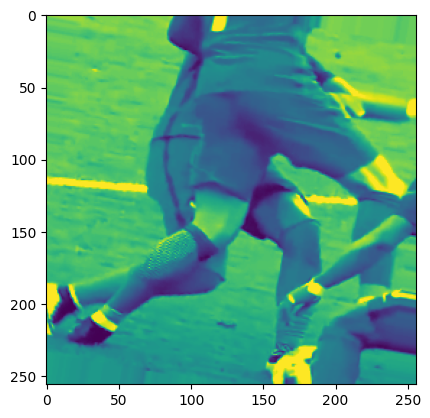

In [237]:
img, label = train_data.next()
print(img.shape)
plt.imshow(img[0])

In [238]:
print(train_data.class_indices)
print(val_data.class_indices)

{'Clean_Tackles': 0, 'Fouls': 1}
{'Clean_Tackles': 0, 'Fouls': 1}


In [240]:
# base_model = EfficientNetB4(input_shape=(224,224,3),weights='imagenet',include_top=False)
# base_model.trainable = False
# model = Sequential()
# model.add(base_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(1,activation='sigmoid'))

In [241]:
clear_session()

In [242]:
# Creating model from scratch:
inputs=Input(shape=(256,256,1))
x = Conv2D(64,5,padding='same')(inputs)
x = Activation(activation='relu')(x)
x = MaxPool2D(strides=(2,2))(x)
x = Conv2D(64,5,padding='same')(x)
x = Activation(activation='relu')(x)
x = MaxPool2D(strides=(2,2))(x)
x = Conv2D(64,5,padding='same')(x)
x = Activation(activation='relu')(x)
x = MaxPool2D(strides=(2,2))(x)

 #Decreasing Filters and MAxPool Layers
x = Conv2D(32,3,padding='same',dilation_rate=2)(x)
x = Activation(activation='relu')(x)
# x = BatchNormalization()(x)
x = MaxPool2D(strides=(2,2))(x)
x = Conv2D(16,3,padding='same',dilation_rate=2)(x)
x = Activation(activation='relu')(x)
x = MaxPool2D(strides=(2,2))(x)
# x = BatchNormalization()(x)
x = Conv2D(16,3,padding='same',dilation_rate=2)(x)
x = Activation(activation='relu')(x)
x = MaxPool2D(strides=(2,2))(x)

 #Dense Layers
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(400)(x)
x = Dropout(0.5)(x)
x = Activation(activation='relu')(x)
x = Dense(512)(x)
x = Dropout(0.5)(x)
x = Activation(activation='relu')(x)
x = Dense(400)(x)
x = Dropout(0.5)(x)
x = Activation(activation='relu')(x)
x = Dense(1)(x)

#Output
out = Activation(activation='sigmoid')(x)

# final model:
model = Model(inputs,out,name='BaseModel')

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

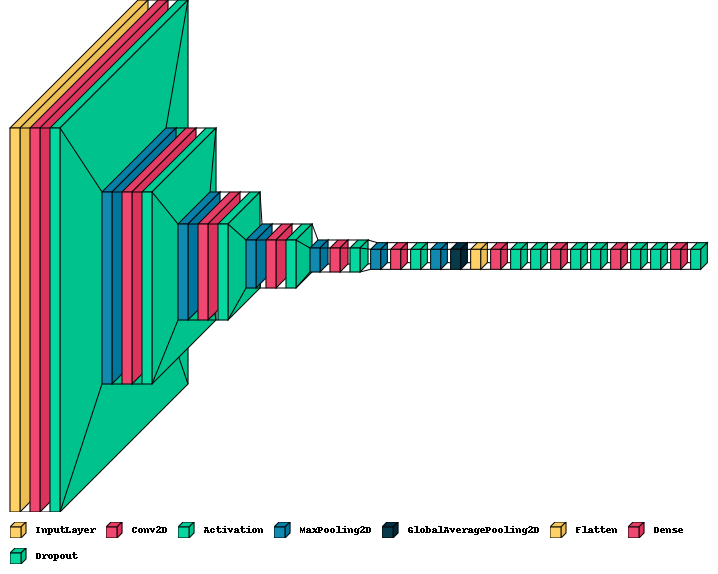

In [278]:
visualkeras.layered_view(model, legend=True, scale_xy=1.5, max_z=10,draw_volume=True)

In [294]:
%%capture
plot_model(model, show_shapes=True, show_layer_activations=True, dpi=64, to_file='model1.png')

In [244]:
# training model:
es=EarlyStopping(monitor='val_accuracy',patience=7,verbose=0,restore_best_weights=True)
logs=model.fit(train_data,validation_data=val_data,epochs=100,callbacks=[es])

Epoch 1/100
31/31 [==============================] - 16s 385ms/step - loss: 0.6938 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.5083
Epoch 2/100
31/31 [==============================] - 11s 366ms/step - loss: 0.6939 - accuracy: 0.5031 - val_loss: 0.6937 - val_accuracy: 0.5083
Epoch 3/100
31/31 [==============================] - 11s 361ms/step - loss: 0.6940 - accuracy: 0.4927 - val_loss: 0.6930 - val_accuracy: 0.5083
Epoch 4/100
31/31 [==============================] - 11s 366ms/step - loss: 0.6937 - accuracy: 0.4730 - val_loss: 0.6929 - val_accuracy: 0.5083
Epoch 5/100
31/31 [==============================] - 11s 363ms/step - loss: 0.6882 - accuracy: 0.5405 - val_loss: 0.6005 - val_accuracy: 0.7500
Epoch 6/100
31/31 [==============================] - 11s 369ms/step - loss: 0.6892 - accuracy: 0.5560 - val_loss: 0.6858 - val_accuracy: 0.5917
Epoch 7/100
31/31 [==============================] - 11s 363ms/step - loss: 0.6894 - accuracy: 0.5228 - val_loss: 0.6327 - val_accuracy:

In [245]:
clear_session()

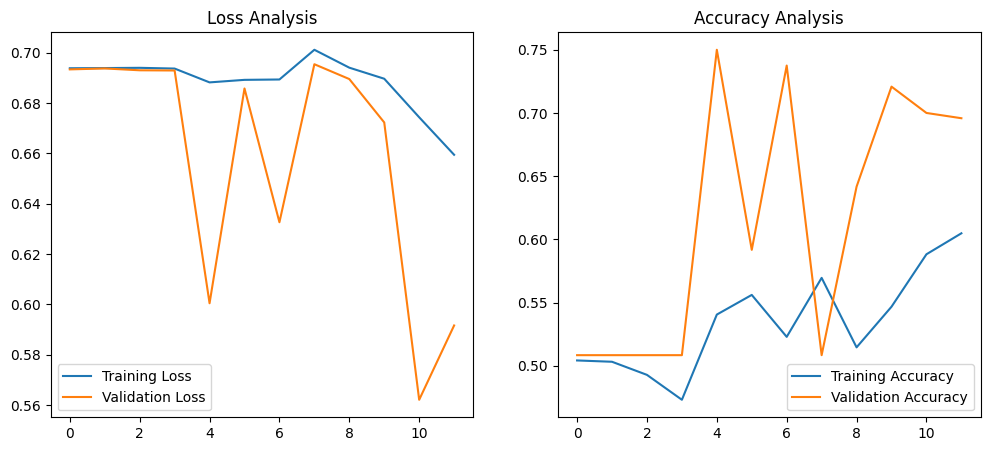

In [246]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(logs.history['loss'], label='Training Loss')
plt.plot(logs.history['val_loss'], label='Validation Loss')
plt.title('Loss Analysis')
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs.history['accuracy'], label='Training Accuracy')
plt.plot(logs.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Analysis')
plt.legend()
plt.show()

In [247]:
model.evaluate(val_data)

8/8 [==============================] - 2s 286ms/step - loss: 0.5956 - accuracy: 0.7542


[0.5956175327301025, 0.7541666626930237]

In [248]:
model.save('/kaggle/working/model_improved.h5')

## Final validation accuracy: ~76%